In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unyt import Myr

from synthesizer.grid import Grid, get_available_lines
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.sed import Sed
from synthesizer.filters import UVJ
import numpy as np
from synthesizer.filters import Filter, FilterCollection
from synthesizer.exceptions import WavelengthOutOfRange, InconsistentWavelengths
import matplotlib as mpl
import matplotlib.cm as cm
import os
from unyt import Angstrom, Hz, um, eV
from synthesizer.igm import Madau96

# SED objects Tutorial


In [2]:

# Define the grid
grid_name = "bc03_chabrier03-0.1,100.hdf5"
grid_dir = "/Users/am/Documents/CAMELS/camels/synthesizer/data/grids/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.10000158  5.15000075  5.19999913  5.25000014  5.30000167
  5.35000172  5.40000062  5.45000109  5.50000169  5.55000197  5.600002
  5.65000234  5.7000024   5.75000207  5.80000252  5.85000259  5.90000315
  5.95000295  6.          6.0200006   6.04000071  6.05999863  6.0799984
  6.10000158  6.12000107  6.13999866  6.16000007  6.17999964  6.19999913
  6.22000081  6.23999979  6.2599998   6.27999984  6.2999995   6.31999873
  6.33999968  6.36000044  6.37999947  6.39999889  6.42000033  6.4400002
  6.45999977  6.47999975  6.49999895  6.51999984  6.53999893  6.55999993
  6.57999955  6.59999981  6.6199996   6.63999917  6.65999982  6.67999901
  6.69999893  6.71999962  6.73999931  6.75999929  6.77999958  6.79999907
  6.81999905  6.83999939  6.85999942  6.8799991   6.89999932  6.91999908
  6.93999921  6.95999912  6.97999882  6.99999913  7.0200006   7.04000071
  7.05999863  7.0799984   7.09999813  7.11999778  7.13999866  7.1600000

In [3]:
# create a galaxy from our snapshot data
gals = load_CAMELS_IllustrisTNG(
    "../../synthesizer/tests/data/",
    snap_name="snap_000.hdf5",
    fof_name="fof_subhalo_tab_000.hdf5",
)

len(gals)

/Users/am/anaconda3/envs/allyenv/lib/python3.9/site-packages/unyt/array.py:1938: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


10830

In [4]:
print(gals)

[<synthesizer.particle.galaxy.Galaxy object at 0x107a48fd0>, <synthesizer.particle.galaxy.Galaxy object at 0x107a85130>, <synthesizer.particle.galaxy.Galaxy object at 0x107a85a60>, <synthesizer.particle.galaxy.Galaxy object at 0x107a859d0>, <synthesizer.particle.galaxy.Galaxy object at 0x107a85910>, <synthesizer.particle.galaxy.Galaxy object at 0x107a85e50>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2fd0>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2c10>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2580>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2400>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c25b0>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2040>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2f10>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c25e0>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2bb0>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2b20>, <synthesizer.particle.galaxy.Galaxy obj

In [5]:
# Convert Grid into SED
# Get the sed object
sed = grid.get_sed(spectra_type="stellar")

# Measure the balmer break for all spectra in the grid (limiting the output)
sed.measure_balmer_break()[5:10, 5:10]

unyt_array([[0.67812718],
       [0.67865743],
       [0.67915791],
       [0.67987413],
       [0.68039133]], '(dimensionless)')

In [6]:
# get grid metalicity and SED
log10age = 6.0  # log10(age/yr)
metallicity = 0.01
spectra_id = "stellar"
grid_point = grid.get_grid_point((log10age, metallicity))
sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
sed.lnu *= 1e8  # make the SED bigger

In [7]:
print(sed)


----------
SUMMARY OF SED 
Number of wavelength points: 6900 
Wavelength range: [91.00 Å,             1600000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             29.08 
log10(Bolometric luminosity/erg/s):36.571308890664774----------


In [8]:
print('wavelength:', sed.lam)
print('luminosity:',sed.lnu)

wavelength: [9.1e+01 9.4e+01 9.6e+01 ... 1.2e+06 1.4e+06 1.6e+06] Å
luminosity: [6.69354123e+16 1.76478872e+17 3.29299242e+17 ... 4.79460439e+23
 3.50264056e+23 2.66802978e+23] erg/(Hz*s)


In [9]:
# now get the filter codes for XMM-OM
lams_xmm = np.linspace(1883.78, 2994.45, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_XMM = Filter("XMM/OM.UVM2", new_lam=lams_xmm)

# filter_codes = [f"JWST/NIRCam.{f}" for f in ["F070W", "F444W"]]
filter_codes = ["XMM/OM.UVM2"] 
svo_fil_xmm = FilterCollection(filter_codes=filter_codes, new_lam=lams_xmm)


In [10]:
# now get for UVOT
lams_uvot = np.linspace(1699.08, 2964.30, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2", new_lam=lams_xmm)

filter_codes = ["Swift/UVOT.UVM2",  "XMM/OM.UVM2"] 

svo_fil_uvot = FilterCollection(filter_codes=filter_codes, new_lam=lams_uvot)

In [11]:
# make filter collection with both UVOT and OM 
filt_lst = [fil_uvm2_UVOT, fil_uvm2_XMM]

combined_filters = FilterCollection(
    filters=filt_lst, new_lam=lams_xmm
)

In [12]:
print('Filter codes: ', filter_codes)
fc = FilterCollection(filter_codes, new_lam=grid.lam)

Filter codes:  ['Swift/UVOT.UVM2', 'XMM/OM.UVM2']


In [22]:
# fluxes not calculated from previous cell so use get_fnu
from astropy.cosmology import Planck18 as cosmo

z = 0.5 # redshift
sed.get_fnu(cosmo, z, igm=Madau96)  # generate observed frame spectra

# Measure observed photometry
# Need  sed.get_fnu first
fluxes = sed.get_photo_fluxes(fc)
print(fluxes)


----------------------------------------------------------------
|                      PHOTOMETRY (FLUX)                       |
|----------------------------------|---------------------------|
| Swift/UVOT.UVM2 (λ = 2.25e+03 Å) | 1.23e+04 erg/(Hz*cm**2*s) |
|----------------------------------|---------------------------|
|   XMM/OM.UVM2 (λ = 2.33e+03 Å)   | 1.18e+04 erg/(Hz*cm**2*s) |
----------------------------------------------------------------



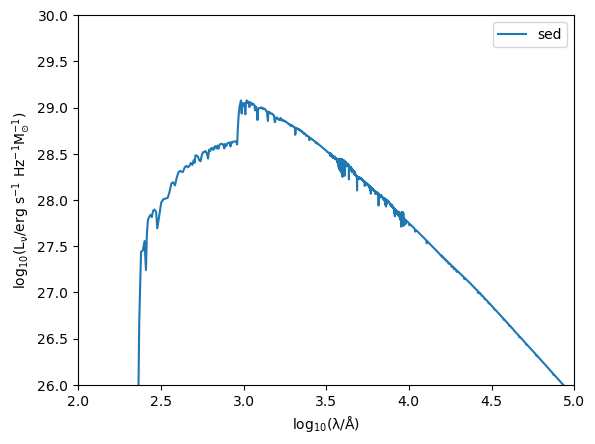

In [23]:
#sed5 = sed + sed
plt.plot(np.log10(sed.lam), np.log10(sed.lnu), label="sed")
#plt.plot(np.log10(sed5.lam), np.log10(sed5.lnu), label="sed5")
plt.ylim(26, 30)
plt.xlim(2, 5)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

It looks like the SED is set from the grid, so I need to figure out how to integrate camels data and the UVM2 filters

# CAMELS EXAMPLE
Use test cosmological simulation data (from the CAMELS simulations) to generate spectra and calculate photometry.



In [24]:
import numpy as np
import matplotlib.pyplot as plt
from unyt import Myr

from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.sed import Sed
from synthesizer.filters import UVJ

In [26]:
# Already defined above but a reminder here:
# Define the grid
#grid_name = "bc03_chabrier03-0.1,100.hdf5"
#grid_dir = "/Users/am/Documents/CAMELS/camels/synthesizer/data/grids/"
#grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.10000158  5.15000075  5.19999913  5.25000014  5.30000167
  5.35000172  5.40000062  5.45000109  5.50000169  5.55000197  5.600002
  5.65000234  5.7000024   5.75000207  5.80000252  5.85000259  5.90000315
  5.95000295  6.          6.0200006   6.04000071  6.05999863  6.0799984
  6.10000158  6.12000107  6.13999866  6.16000007  6.17999964  6.19999913
  6.22000081  6.23999979  6.2599998   6.27999984  6.2999995   6.31999873
  6.33999968  6.36000044  6.37999947  6.39999889  6.42000033  6.4400002
  6.45999977  6.47999975  6.49999895  6.51999984  6.53999893  6.55999993
  6.57999955  6.59999981  6.6199996   6.63999917  6.65999982  6.67999901
  6.69999893  6.71999962  6.73999931  6.75999929  6.77999958  6.79999907
  6.81999905  6.83999939  6.85999942  6.8799991   6.89999932  6.91999908
  6.93999921  6.95999912  6.97999882  6.99999913  7.0200006   7.04000071
  7.05999863  7.0799984   7.09999813  7.11999778  7.13999866  7.1600000

In [25]:
# create a galaxy from our snapshot data
#gals = load_CAMELS_IllustrisTNG(
#    "../../synthesizer/tests/data/",
#    snap_name="snap_000.hdf5",
#    fof_name="fof_subhalo_tab_000.hdf5",
#)
print(gals)
len(gals)

[<synthesizer.particle.galaxy.Galaxy object at 0x107a48fd0>, <synthesizer.particle.galaxy.Galaxy object at 0x107a85130>, <synthesizer.particle.galaxy.Galaxy object at 0x107a85a60>, <synthesizer.particle.galaxy.Galaxy object at 0x107a859d0>, <synthesizer.particle.galaxy.Galaxy object at 0x107a85910>, <synthesizer.particle.galaxy.Galaxy object at 0x107a85e50>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2fd0>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2c10>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2580>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2400>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c25b0>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2040>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2f10>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c25e0>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2bb0>, <synthesizer.particle.galaxy.Galaxy object at 0x1448c2b20>, <synthesizer.particle.galaxy.Galaxy obj

10830

In [49]:
g = gals[1]
print(g)

this creates gals, which is a list containing a synthesizer.Galaxy object for each structure in the subfind file. These Galaxy objects contain lots of useful methods for acting on galaxies, in addition to the component parts of a galaxy. These components include Stars, Gas, and BlackHoles. To generate the intrinsic spectrum of the stellar component we can do the following.



In [43]:
#g = gals[1]
#spec = g.stars.get_spectra_stellar(grid)
# Here we grab a single galaxy, and call stars.get_spectra_incident, providing our grid object as the first argument. 
# This returns the spectra as an Sed object (see the SED docs).
# In this case we only have STELLAR spectra so cannot use get_spectra_incident so lets create an SED object using this method instead:

grid_point = grid.get_grid_point((log10age, metallicity))
print(grid_point)

spectra_id = "stellar"
grid_point = grid.get_grid_point((log10age, metallicity))
sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
sed.lnu *= 1e8  # make the SED bigger

print(sed)

# notice at this point we haven't used gals object at all - this is all the grid.

(19, 3)
----------
SUMMARY OF SED 
Number of wavelength points: 6900 
Wavelength range: [91.00 Å,             1600000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             29.08 
log10(Bolometric luminosity/erg/s):36.571308890664774----------


In [44]:
# continue following tutorial
spec = sed
print(spec)

----------
SUMMARY OF SED 
Number of wavelength points: 6900 
Wavelength range: [91.00 Å,             1600000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             29.08 
log10(Bolometric luminosity/erg/s):36.571308890664774----------


In [45]:
# To access the luminosity and wavelength for _spec we can now do
# Notice that these are unyt arrays with associated units. 
spec.lam[:10], spec.lnu[:10] # this is taken from the grid not the galaxy


(unyt_array([ 91.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.], 'Å'),
 unyt_array([6.69354123e+16, 1.76478872e+17, 3.29299242e+17, 5.84228126e+17,
        1.03047910e+18, 1.80609204e+18, 3.07386827e+18, 5.11450908e+18,
        8.33384387e+18, 1.39890075e+19], 'erg/(Hz*s)'))

Text(0, 0.5, '$L_{\\nu} \\,/\\, \\mathrm{erg \\; s^{-1} \\; Hz^{-1}}$')

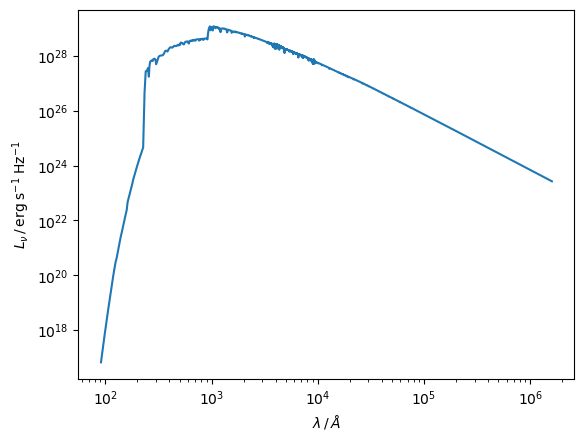

In [46]:
# To plot the spectra manually we can do the following.
plt.loglog(spec.lam, spec.lnu)
plt.xlabel("$\lambda \,/\, \\AA$")
plt.ylabel("$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$")


In [56]:
type(g)

synthesizer.particle.galaxy.Galaxy

In [57]:
print(dir(g.stars))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_ages', '_check_part_args', '_check_star_args', '_check_young_old_units', '_coordinates', '_current_masses', '_get_masks', '_initial_masses', '_masses', '_power_law_sample', '_prepare_sed_args', '_prepare_sfzh_args', '_smoothing_lengths', '_softening_lengths', '_velocities', 'ages', 'alpha_enhancement', 'attrs', 'convert_to_comoving_properties', 'convert_to_physical_properties', 'coordinates', 'current_masses', 'generate_line', 'generate_lnu', 'generate_particle_line', 'generate_particle_lnu', 'get_line_attenuated', 'get_line_intrinsic', 'get_line_screen', 'get_particle_line_attenuated', 'get_particle_line_intrinsic', 'get_particle_line_screen', 

In [69]:

# Example: Assuming the spectra are stored in an attribute named 'spectra'
spectra = g.stars.spectra
print(spectra)
# spectra is empty


{}


In [73]:
spectra_incident = g.stars.get_spectra_incident
print(spectra_incident)


<bound method StarsComponent.get_spectra_incident of <synthesizer.particle.stars.Stars object at 0x107a85970>>


In [74]:
g = gals[1]
spec = g.stars.get_spectra_incident(grid)

MissingSpectraType: The Grid does not contain the key 'incident' 

In [86]:
print(grid)


------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.10000158  5.15000075  5.19999913  5.25000014  5.30000167
  5.35000172  5.40000062  5.45000109  5.50000169  5.55000197  5.600002
  5.65000234  5.7000024   5.75000207  5.80000252  5.85000259  5.90000315
  5.95000295  6.          6.0200006   6.04000071  6.05999863  6.0799984
  6.10000158  6.12000107  6.13999866  6.16000007  6.17999964  6.19999913
  6.22000081  6.23999979  6.2599998   6.27999984  6.2999995   6.31999873
  6.33999968  6.36000044  6.37999947  6.39999889  6.42000033  6.4400002
  6.45999977  6.47999975  6.49999895  6.51999984  6.53999893  6.55999993
  6.57999955  6.59999981  6.6199996   6.63999917  6.65999982  6.67999901
  6.69999893  6.71999962  6.73999931  6.75999929  6.77999958  6.79999907
  6.81999905  6.83999939  6.85999942  6.8799991   6.89999932  6.91999908
  6.93999921  6.95999912  6.97999882  6.99999913  7.0200006   7.04000071
  7.05999863  7.0799984   7.09999813  7.11999778  7.13999866  7.1600000

In [80]:
# Use code from create_gals to get particle galaxy data:
from unyt import Myr
from synthesizer.parametric import SFH, ZDist
from synthesizer.particle.stars import sample_sfhz
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle.particles import CoordinateGenerator
# Define the metallicity history
zh = ZDist.DeltaConstant(metallicity=0.01)
zh 

# Define the star formation history
sfh_p = {"duration": 100 * Myr}
sfh = SFH.Constant(duration=100 * Myr)
sfh



# Initialise the parametric Stars object
param_stars = ParametricStars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=zh,
    initial_mass=10**9,
)
param_stars


# Define the number of stellar particles we want
n = 10000

# Sample the parametric SFZH, producing a particle Stars object
# we will also pass some keyword arguments for some example attributes
part_stars = sample_sfhz(
    sfzh=param_stars.sfzh,
    log10ages=param_stars.log10ages,
    log10metallicities=param_stars.log10metallicities,
    nstar=n,
    current_masses=np.full(n, 10**8.7 / n),
    redshift=1,
    initial_mass=10**6,
)
print(part_stars)

----------
SUMMARY OF STAR PARTICLES
N_stars: 10000
log10(total mass formed/Msol):  10.00
median(age/Myr): 50.0 yr
----------


In [85]:
from synthesizer import galaxy

# Get a particle galaxy
part_gal = galaxy(stars=part_stars, gas=None, black_holes=None, redshift=1)
print(type(part_gal))
print(part_gal)

<class 'synthesizer.particle.galaxy.Galaxy'>


In [84]:
from synthesizer.particle import Galaxy

# Get a particle galaxy
part_gal2 = Galaxy(stars=part_stars, gas=None, black_holes=None, redshift=1)
print(type(part_gal2))
print(part_gal2)

<class 'synthesizer.particle.galaxy.Galaxy'>


In [88]:
# Import Filters from SVO

lams_xmm = np.linspace(1883.78, 2994.45, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_XMM = Filter("XMM/OM.UVM2", new_lam=lams_xmm)
# filter_codes = [f"JWST/NIRCam.{f}" for f in ["F070W", "F444W"]]
filter_codes = ["XMM/OM.UVM2"] 
svo_fil_xmm = FilterCollection(filter_codes=filter_codes, new_lam=lams_xmm)

# now get for UVOT

lams_uvot = np.linspace(1699.08, 2964.30, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2", new_lam=lams_xmm)

filter_codes = ["Swift/UVOT.UVM2"] 
svo_fil_uvot = FilterCollection(filter_codes=filter_codes, new_lam=lams_uvot)

filt_lst = [fil_uvm2_UVOT, fil_uvm2_XMM]

combined_filters = FilterCollection(
    filters=filt_lst, new_lam=lams_xmm
)
# Loop over them:
print("My Filters:")
for f in combined_filters:
    print(f.filter_code)



My Filters:
Swift/UVOT.UVM2
XMM/OM.UVM2


In [91]:
photo_lums = g.get_photo_luminosities(combined_filters)
print(photo_lums)


None


In [92]:
print("Stellar luminosities available:", list(g.stars.photo_luminosities.keys()))


Stellar luminosities available: []
